In [1]:
import os
import zipfile

local_zip = os.path.join( os.getcwd(),r'tmp2\happy-or-sad.zip')
zip_ref = zipfile.ZipFile(local_zip, 'r')
path = os.path.join(os.getcwd(),r'tmp2\happy-or-sad')
zip_ref.extractall(path)
zip_ref.close()

In [2]:
# seeing total files in the dataset
train_happy_dir = os.path.join(path,r'happy')
train_happy_names = os.listdir(train_happy_dir)
print("total happy images :",len(train_happy_names)) # printing first 10 files : 
train_sad_dir = os.path.join(path,r'sad')
train_sad_names = os.listdir(train_sad_dir)
print("total sad images :",len(train_sad_names))

total happy images : 40
total sad images : 40


In [3]:
# importing mobile net for our purpose 
import tensorflow as tf
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2

model = MobileNetV2(include_top = False,
                    input_shape = (150,150,3),
                    weights = 'imagenet')
model.summary()

C:\Users\shaur\anaconda3\lib\site-packages\keras_applications\mobilenet_v2.py:294: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  warnings.warn('`input_shape` is undefined or non-square, '


Model: "mobilenetv2_1.00_224"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 150, 150, 3) 0                                            
__________________________________________________________________________________________________
Conv1_pad (ZeroPadding2D)       (None, 151, 151, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv1 (Conv2D)                  (None, 75, 75, 32)   864         Conv1_pad[0][0]                  
__________________________________________________________________________________________________
bn_Conv1 (BatchNormalization)   (None, 75, 75, 32)   128         Conv1[0][0]                      
_______________________________________________________________________________

In [4]:
model = tf.keras.Model(model.input,model.get_layer('block_16_project_BN').output)

In [6]:
model.trainable = False
tmodel = tf.keras.Sequential([
        model,
        tf.keras.layers.Flatten(),
        tf.keras.layers.Dense(64,activation = 'relu'),
        tf.keras.layers.Dense(1,activation = 'sigmoid')
])
tmodel.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
model (Model)                (None, 5, 5, 320)         1843264   
_________________________________________________________________
flatten (Flatten)            (None, 8000)              0         
_________________________________________________________________
dense (Dense)                (None, 64)                512064    
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 65        
Total params: 2,355,393
Trainable params: 512,129
Non-trainable params: 1,843,264
_________________________________________________________________


In [7]:
from tensorflow.keras.optimizers import RMSprop

tmodel.compile(loss='binary_crossentropy',
              optimizer=RMSprop(lr=0.001),
              metrics=['accuracy'])

from tensorflow.keras.preprocessing.image import ImageDataGenerator
train_datagen = ImageDataGenerator(rescale=1/255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   rotation_range = 40,
                                   horizontal_flip = True,
                                   fill_mode = 'nearest') # Data augmentation  

# Flow training images in batches of 128 using train_datagen generator
train_generator = train_datagen.flow_from_directory(
        path,  # This is the source directory for training images
        target_size=(150,150),  # All images will be resized to 150x150
        batch_size=10, # since total 80 images so per step we can process 10 images thus 8 steps per epochs will work
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')


Found 80 images belonging to 2 classes.


In [8]:
history = tmodel.fit(
      train_generator,
      steps_per_epoch=8,  
      epochs=20,
      verbose=1,) 

Train for 8 steps
Epoch 1/20
8/8 [==============================] - 7s 883ms/step - loss: 1.1917 - accuracy: 0.9000
Epoch 2/20
8/8 [==============================] - 4s 505ms/step - loss: 0.5436 - accuracy: 0.9250
Epoch 3/20
8/8 [==============================] - 4s 523ms/step - loss: 0.1888 - accuracy: 0.9500
Epoch 4/20
8/8 [==============================] - 5s 611ms/step - loss: 0.2690 - accuracy: 0.9375
Epoch 5/20
8/8 [==============================] - 6s 783ms/step - loss: 0.1977 - accuracy: 0.9500
Epoch 6/20
8/8 [==============================] - 7s 903ms/step - loss: 0.0618 - accuracy: 0.9750
Epoch 7/20
8/8 [==============================] - 4s 531ms/step - loss: 0.0983 - accuracy: 0.9500
Epoch 8/20
8/8 [==============================] - 6s 802ms/step - loss: 0.2852 - accuracy: 0.9500
Epoch 9/20
8/8 [==============================] - 7s 888ms/step - loss: 0.0625 - accuracy: 0.9875
Epoch 10/20
8/8 [==============================] - 4s 510ms/step - loss: 0.0027 - accuracy: 1.0000
E

[0.19661273]
given image is happy
[0.9904884]
given image is sad
[0.9810585]
given image is sad
[0.05609239]
given image is happy


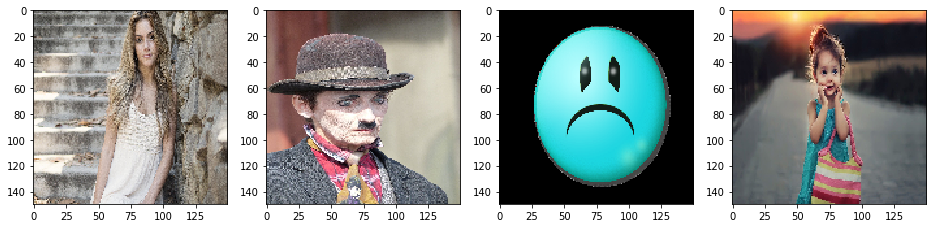

In [13]:
# clearly we overfit but let's test it out on sample images to see how good a classifier it is :
import numpy as np
from keras.preprocessing import image
import matplotlib.pyplot as plt
def model_pred(image):
    classes = tmodel.predict(image)
    print(classes[0])
    if(classes[0] > 0.5):
        print("given image is sad")
    else:
        print("given image is happy")
        
def imgreturn(path):
    uploaded_path = path
    d = img = image.load_img(uploaded_path,target_size=(150,150)) # converted a high pixel image into 150x150
    x = image.img_to_array(img)
    #print(x)                              # array of pixel data
    x = x/255
    #plt.imshow(img)                       # image printed in 150x150
    x = np.expand_dims(x, axis=0) 
    #print(x.shape) # setting dimensions for the model to predict  (1,150,150,3) 1 is by axis = 0
    return x,d

pathe = os.path.join(os.getcwd(),r'tmp2\Sample images') 
x,fx = imgreturn(os.path.join(pathe,r'beautiful-1274056_1920.jpg'))
x1,fx1 = imgreturn(os.path.join(pathe,r"charlie-chaplin-898308_1280.jpg"))
x2,fx2 = imgreturn(os.path.join(pathe,r"emoticon-937608_1920.png"))
x3,fx3 = imgreturn(os.path.join(pathe,r"girl-738302_1280.jpg"))
f,axarr = plt.subplots(1,4)
f.set_size_inches( 16, 16) 
axarr[0].imshow(fx)
axarr[1].imshow(fx1)
axarr[2].imshow(fx2)
axarr[3].imshow(fx3)
#images = np.vstack([x,x1,x2,x3])
model_pred(x)
model_pred(x1)
model_pred(x2)
model_pred(x3)

## This time it worked great because of all those pre trained layers !!